In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd
from hilbertcurve.hilbertcurve import HilbertCurve
import seaborn as sns

import multiprocessing
from multiprocessing import Value, Pool

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
import tensorflow as tf

from tqdm import tqdm

import pickle
import glob
import requests, json
import re
from functools import partial
from PIL import Image

path = '/home/s2316002/Project2/'

Matplotlib created a temporary cache directory at /tmp/matplotlib-8sgp0cic because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def read_newDB():
    feature=["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot",
          "num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells",
          "num_access_files","num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate",
          "rerror_rate","srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
          "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
          "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label","difficulty"]
    
    dftest = pd.read_csv('/home/s2316002/Project2/Dataset/KDDTest+.txt',names = feature)
    
    dftest.loc[dftest['label'] == "normal", "label"] = 0
    dftest.loc[dftest['label'] != 0, "label"] = 1

    dftest.label = dftest.label.astype('int')
    dftest.to_csv('/home/s2316002/Project2/Dataset/KDDTest+.csv', index =False)

    # scaler = MinMaxScaler()
    # dftest[dftest.columns] = scaler.fit_transform(dftest[dftest.columns])
    
    return dftest

def read_DB():
    return pd.read_csv('/home/s2316002/Project2/Dataset/KDDTrain+.csv')

In [3]:
def load_image(filename):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        with Image.open(filename).convert('L') as img:
            if img is not None:
                return filename, np.array(img)

def load_images_from_folder(folder):
    pool = Pool(5)
    images = pool.map(load_image, sorted(glob.glob(os.path.join(folder, '*.[jp][np]g'))))
    pool.close()
    pool.join()
    # Sort images based on filename
    images = sorted(images, key=lambda x: int(re.findall(r'\d+', x[0].split('/')[-1])[0]))
    # Remove filenames
    images = [img for _, img in images]
    return images
    
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('on')  # Turn off axes
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Eliminate margins

In [4]:
model = keras.models.load_model(path+'/Model/netflow_hilbert.h5')

In [5]:
test_image = load_images_from_folder(path + 'netflow/TestImages')
test_image = np.array(test_image)

In [6]:
test = read_newDB()
y_test = test.label
y_test = y_test[63:]

In [7]:
results = model.evaluate(test_image, y_test, verbose=0)

# Results is a list with the loss and all the metrics
print('Test loss:', results[0])

# If you have multiple metrics, they will be in the rest of the list
for i in range(1, len(model.metrics_names)):
    print(f'Test {model.metrics_names[i]}:', results[i])

Test loss: 19.096593856811523
Test accuracy: 0.726213276386261
Test mse: 11204654.0


In [8]:
y_pred_probs = model.predict(test_image)
y_pred = (y_pred_probs > 0.5).astype('int32')

# Calculate metrics
f1 = f1_score(y_test, y_pred, average='binary')
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# True positives, False positives, etc
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

# True positive rate (sensitivity or recall)
TPR = TP / (TP + FN)
# True negative rate (specificity)
TNR = TN / (TN + FP)
# False positive rate (1 - specificity)
FPR = FP / (TN + FP)
# False negative rate (1 - sensitivity)
FNR = FN / (TP + FN)

# Print metrics
print("F1 score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Confusion Matrix: \n", cm)
print("FPR: ", FPR)
print("FNR: ", FNR)
print("TPR: ", TPR)
print("TNR: ", TNR)

703/703 [==============================] - 3s 4ms/step
F1 score:  0.6918031145160484
Precision:  0.9634588563458857
Recall:  0.5396453402077963
Confusion Matrix: 
 [[9418  262]
 [5893 6908]]
FPR:  0.02706611570247934
FNR:  0.46035465979220375
TPR:  0.5396453402077963
TNR:  0.9729338842975207


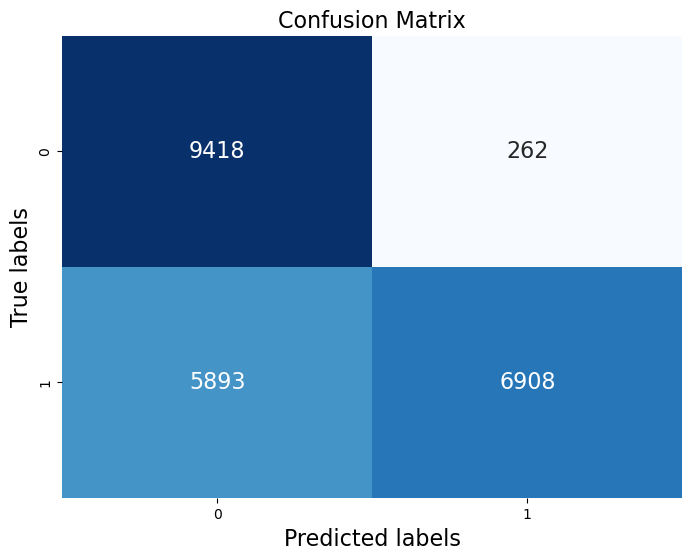

In [9]:
# Confusion matrix
cm = [[TN, FP],
      [FN, TP]]
# Create a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})

# Labels, title and ticks
label_font = {'size':'16'}  # Adjust to fit
plt.xlabel('Predicted labels', fontdict=label_font)
plt.ylabel('True labels', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=label_font)

plt.show()
